In [1]:
import tensorflow as tf
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# Define commands and paths
commands = ['cat', 'dog', 'bird']
data_dir = 'E:\study\رابعه\Machine Learning\project\Learn App\Train Animals'

# Helper function to load audio files
def load_audio_files(data_dir, commands):
    audio_data = []
    labels = []
    for label, command in enumerate(commands):
        command_path = os.path.join(data_dir, command)
        for file in os.listdir(command_path):
            try:
                file_path = os.path.join(command_path, file)
                audio, sr = librosa.load(file_path, sr=16000)
                audio_data.append(audio)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return np.array(audio_data, dtype=object), np.array(labels)

# Load the data
audio_data, labels = load_audio_files(data_dir, commands)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12488\4278073666.py:9: SyntaxWarning: invalid escape sequence '\s'
  data_dir = 'E:\study\رابعه\Machine Learning\project\Learn App\Train Animals'


In [2]:
def extract_features(audio_data, max_length=16000):
    features = []
    for audio in audio_data:
        # Pad or truncate audio to fixed length
        audio = librosa.util.fix_length(audio, size=max_length)
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
        features.append(mfcc)
    return np.array(features)

# Extract features
features = extract_features(audio_data)

# Normalize and reshape
features = np.expand_dims(features, -1)  # Add channel dimension for CNN
labels = tf.keras.utils.to_categorical(labels, num_classes=len(commands))

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [93]:
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
input_shape = X_train.shape[1:]  # e.g., (40, 100, 1)
model = build_model(input_shape, len(commands))


In [94]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    callbacks=[early_stopping],
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/50


156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4758 - loss: 2.0380 - val_accuracy: 0.7285 - val_loss: 0.9366
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7600 - loss: 0.9343 - val_accuracy: 0.8932 - val_loss: 0.6370
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8465 - loss: 0.7150 - val_accuracy: 0.9084 - val_loss: 0.5247
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8797 - loss: 0.6153 - val_accuracy: 0.9357 - val_loss: 0.4481
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8916 - loss: 0.5551 - val_accuracy: 0.9382 - val_loss: 0.4115
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9129 - loss: 0.4687 - val_accuracy: 0.9486 - val_loss: 0.3684
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9105 - loss: 0.4512 - val_accuracy: 0.9486 - val_loss: 0.3286
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9321 - loss: 0.3871 - val_accuracy: 0.952

In [106]:
model.save('animalsv3.h5')

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9757 - loss: 0.1146
Test Accuracy: 97.59%


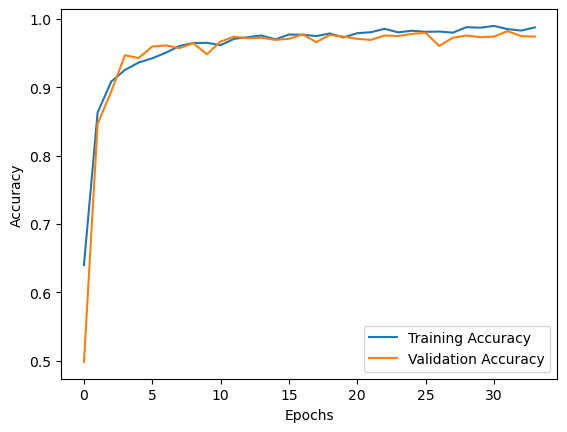

In [75]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Visualize training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [109]:
import sounddevice as sd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to record audio
def record_audio(duration=2, sample_rate=16000):
    print("Recording...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='int16')
    sd.wait()  # Wait until recording is finished
    print("Recording complete.")
    return audio_data.flatten(), sample_rate

# Convert audio data to floating-point and normalize
def normalize_audio(audio):
    return audio.astype(np.float32) / 32768.0  # Normalize to range [-1, 1]

# Extract MFCC features from the audio
def extract_mfcc(audio, sr, duration=2, n_mfcc=40, frames=32):
    # Normalize the audio
    audio = normalize_audio(audio)
    
    # Extract MFCC features from audio
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Ensure the MFCC has the right number of frames (pad or trim)
    if mfcc.shape[1] < frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, frames - mfcc.shape[1])), mode='constant')
    elif mfcc.shape[1] > frames:
        mfcc = mfcc[:, :frames]
    
    # Reshape to match model input (1, 40, 32, 1)
    mfcc = np.expand_dims(mfcc, axis=-1)  # Add channel dimension
    mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension
    
    return mfcc

# Function to recognize command from recorded audio
def recognize_command_from_microphone(model, duration=2, commands=None):
    # Record audio
    audio, sr = record_audio(duration=duration)

    # Extract MFCC features
    mfcc = extract_mfcc(audio, sr, duration)
    
    print(f"MFCC shape: {mfcc.shape}")  # Check MFCC shape
    
    # Predict the command
    prediction = model.predict(mfcc)
    predicted_command = commands[np.argmax(prediction)]  # Get the label with the highest prediction score

    print(f"Recognized Command: {predicted_command}")

# Example usage
commands = ['cat', 'dog', 'bird']  # List of your command labels
model = load_model('animalsv3.h5')  # Load your trained model
recognize_command_from_microphone(model, duration=2, commands=commands)


Recording...
Recording complete.
MFCC shape: (1, 40, 32, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Recognized Command: bird
